# Surrogate models for climate metrics

The purpose of this notebook is to provide regression models to calculate climate metrics as functions of time horizon and aviation species settings (sensitivity to emissions, ERF/RF and efficacy):
$$ Metric = f(H, \sigma, \eta, r) $$

The regression models are fitted here on FaIR's outputs.

In [1]:
# Import libraries
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import qmc
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

# Climate functions
from aerocm.metrics.aviation_climate_metrics_calculation import AviationClimateMetricsCalculation

## Sampling

In [2]:
# Define variable bounds (in log-space)
variables = {"time_horizon_log": (np.log(10), np.log(200))}

# Generate Latin Hypercube samples
n_samples = 100
sampler = qmc.LatinHypercube(d=len(variables))
sample = sampler.random(n=n_samples)  # scaled between 0 and 1

# Rescale samples to variable bounds
l_bounds, u_bounds = zip(*variables.values())
scaled_sample = qmc.scale(sample, l_bounds, u_bounds)

# Round to integer years in original space, then convert back to log --> ensure further processing with time horizons will use int years
scaled_sample = np.log(np.exp(scaled_sample).astype(int))
df_samples = pd.DataFrame(scaled_sample, columns=variables.keys())
df_samples

,time_horizon_log
0,3.828641
1,2.708050
2,4.406719
3,2.890372
4,5.278115
...,...
95,2.302585
96,2.890372
97,4.234107
98,2.564949


## Calculate metrics

In [3]:
# --- Set parameters ---

## Climate model
climate_model = "FaIR"
start_year = 1940

## Metrics
time_horizon = np.zeros(n_samples, dtype=int)
for i, log_horizon in tqdm(enumerate(df_samples["time_horizon_log"]), total=n_samples, leave=False):
    time_horizon[i] = int(np.exp(log_horizon))  # integer time horizons are required by AviationClimateMetricsCalculation class

## Species
species_profile = 'pulse'
profile_start_year = 2020
species_list = ["Contrails", "NOx - ST O3 increase", "NOx - CH4 decrease and induced", "H2O", "Soot", "Sulfur"]

In [4]:
# --- Run simulation ---

results = AviationClimateMetricsCalculation(
    climate_model,
    start_year,
    time_horizon,
    species_profile,
    profile_start_year,
    species_list   
).run()

In [5]:
# --- Store data ---

all_results = []

for species in species_list:
    
    species_results = []

    gwp_rf = np.zeros(n_samples)
    gwp_erf = np.zeros(n_samples)
    egwp_rf = np.zeros(n_samples)
    egwp_erf = np.zeros(n_samples)
    gtp = np.zeros(n_samples)
    igtp = np.zeros(n_samples)
    ratr = np.zeros(n_samples)
    for k in range(0, n_samples):
        th = time_horizon[k]
        gwp_rf[k] = results[th][species]["gwp_rf"]
        gwp_erf[k] = results[th][species]["gwp_erf"]
        egwp_rf[k] = results[th][species]["egwp_rf"]
        egwp_erf[k] = results[th][species]["egwp_erf"]
        gtp[k] = results[th][species]["gtp"]
        igtp[k] = results[th][species]["igtp"]
        ratr[k] = results[th][species]["ratr"]
    
        species_results.append({
                "species": species,
                "time_horizon": time_horizon[k],
                "GWP_RF": gwp_rf[k],
                "GWP_ERF": gwp_erf[k],
                "EGWP_RF": egwp_rf[k],
                "EGWP_ERF": egwp_erf[k],
                "GTP": gtp[k],
                "iGTP": igtp[k],
                "RATR": ratr[k],
            })

    all_results.extend(species_results)

df = pd.DataFrame(all_results)
print(df.head())

     species  time_horizon      GWP_RF    GWP_ERF    EGWP_RF   EGWP_ERF  \
0  Contrails            46   44.372480  18.636442  18.636442  18.636442   
1  Contrails            15  110.423948  46.378058  46.378058  46.378058   
2  Contrails            82   27.427611  11.519597  11.519597  11.519597   
3  Contrails            17   99.694181  41.871556  41.871556  41.871556   
4  Contrails           195   12.850541   5.397227   5.397227   5.397227   

         GTP       iGTP       RATR  
0   2.997713  22.949278  22.949278  
1  15.526451  62.632247  62.632247  
2   1.727030  13.864820  13.864820  
3  13.267446  55.957480  55.957480  
4   1.170704   6.674955   6.674955  


## Fit regression models

### Model 1 (power law)
$$ \log(\text{metric}) = a_1 + b_1 \log(\text{time horizon}) $$
$$ \text{metric} = e^{a_1} \text{time horizon}^{b_1} $$

### Model 2 (log-quadratic model)
$$ \log(\text{metric}) = a_2 + b_2 \log(\text{time horizon}) + c_2 [\log(\text{time horizon})]^2 $$
$$ \text{metric} = e^{a_2} \text{time horizon}^{b_2 + c_2 \log(\text{time horizon})} $$

In [6]:
def fit_log_models(df, species, metric):
    """
    Fit two regression models for a given species and metric:
      - Model 1: linear in log(feature)
      - Model 2: quadratic in log(feature)
    
    Args:
        df (pd.DataFrame): DataFrame containing columns ['species', 'time_horizon', metric]
        species (str): species name to filter the data
        metric (str): column name of the metric to fit
        
    Returns:
        dict: containing Model1, Model2, analytical expressions, and errors
    """
    # Filter data for species
    df_s = df[df["species"] == species].copy()
    if df_s.empty:
        raise ValueError(f"No data found for species '{species}'")
    
    # Prepare features
    X = df_s[["time_horizon"]].copy()
    X["time_horizon_log"] = np.log(X["time_horizon"])
    X["time_horizon_log_2"] = X["time_horizon_log"] ** 2
    y = np.log(df_s[metric]) if species != "NOx - CH4 decrease and induced" else np.log(-df_s[metric])
    
    # Model 1: linear in log(time_horizon)
    model1 = LinearRegression().fit(X[["time_horizon_log"]], y)
    a1 = model1.intercept_
    b1 = model1.coef_[0]
    eq1_log = f"log({metric}) = {a1:.4f} + {b1:.4f} × log(time_horizon)"
    eq1 = f"{metric} = {np.exp(a1):.4f} × time_horizon^{b1:.4f}"
    y_pred1 = model1.predict(X[["time_horizon_log"]])
    r2_1 = r2_score(np.exp(y), np.exp(y_pred1))
    
    # Model 2: quadratic in log(time_horizon)
    model2 = LinearRegression().fit(X[["time_horizon_log", "time_horizon_log_2"]], y)
    a2 = model2.intercept_
    b2, c2 = model2.coef_
    eq2_log = f"log({metric}) = {a2:.4f} + {b2:.4f} × log(time_horizon) + {c2:.4f} × log(time_horizon)^2"
    eq2 = f"{metric} = {np.exp(a2):.4f} × time_horizon^({b2:.4f} + {c2:.4f} × log(time_horizon))"
    y_pred2 = model2.predict(X[["time_horizon_log", "time_horizon_log_2"]])
    r2_2 = r2_score(np.exp(y), np.exp(y_pred2))
    
    return {
        "Model1": model1,
        "Model2": model2,
        "eq1_log": eq1_log,
        "eq1": eq1,
        "eq2_log": eq2_log,
        "eq2": eq2,
        "R2_1": r2_1,
        "R2_2": r2_2,
        "df": pd.DataFrame({"y": np.exp(y), "y_pred1": np.exp(y_pred1), "y_pred2": np.exp(y_pred2)})
    }


def plot_surrogate(results, bin_width: float = 1.0, savefig=False):
    """
    Plot the results of the model fitting with an observed-estimated chart and an histogram of errors.
    """
    # Retrieve results
    y = results["df"]["y"]
    y_pred1 = results["df"]["y_pred1"]
    y_pred2 = results["df"]["y_pred2"]
    residuals_1 = (y_pred1 - y) / y * 100
    residuals_2 = (y_pred2 - y) / y * 100
    mean_error1 = np.mean(residuals_1)
    mean_error2 = np.mean(residuals_2)
    r21 = results['R2_1']
    r22 = results['R2_2']

    # Set figures
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))

    # Observed-estimated chart
    axes[0].scatter(y, y_pred1, label='Model 1 - '+f'R² = {r21:.3f}', alpha=0.7)
    axes[0].scatter(y, y_pred2, label='Model 2 - '+f'R² = {r22:.3f}', alpha=0.7)
    axes[0].plot([np.min(y), np.max(y)], [np.min(y), np.max(y)], color='black')
    axes[0].set_xlabel(r"Observed")
    axes[0].set_ylabel(r"Estimated")
    axes[0].legend()
    axes[0].grid(True)

    # Regression errors histogram
    combined_min = min(residuals_1.min().item(), residuals_2.min().item())
    combined_max = max(residuals_1.max().item(), residuals_2.max().item())
    bins = np.arange(combined_min, combined_max + bin_width, bin_width)
    axes[1].hist(residuals_1, bins=bins, color='C0', edgecolor='black', alpha=0.7)
    axes[1].hist(residuals_2, bins=bins, color='C1', edgecolor='black', alpha=0.7)
    axes[1].axvline(mean_error1, color='C0', linestyle='--', linewidth=2, label='Model 1 - '+f'Mean error: {mean_error1:.2f}')
    axes[1].axvline(mean_error2, color='C1', linestyle='--', linewidth=2, label='Model 2 - 'f'Mean error: {mean_error2:.2f}')
    axes[1].set_xlabel("Relative Error [%]")
    axes[1].set_ylabel("Frequency [%]")
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    if savefig:
        plt.savefig("figures/surrogate_model.pdf")
    plt.show()

    return fig, axes

## Applications

### r-ATR for NOx

RATR = 2730.9966 × time_horizon^-0.6727
RATR = 591.3684 × time_horizon^(0.1870 + -0.1141 × log(time_horizon))
Model 1 R²: 0.9524
Model 2 R²: 0.9987


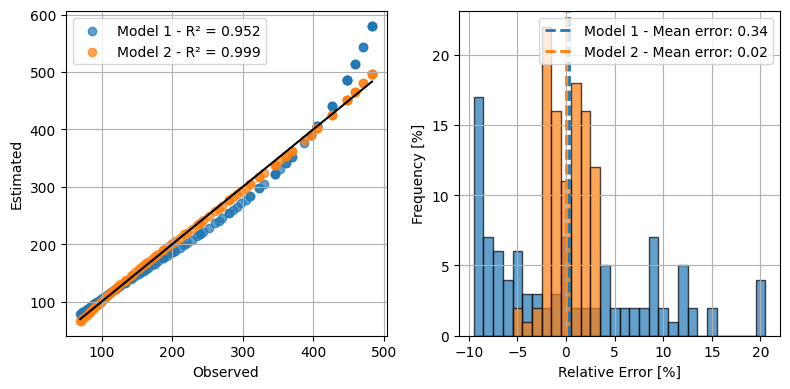

(<Figure size 800x400 with 2 Axes>,
 array([<Axes: xlabel='Observed', ylabel='Estimated'>,
        <Axes: xlabel='Relative Error [%]', ylabel='Frequency [%]'>],
       dtype=object))

In [7]:
# Set species and metric to estimate
species="NOx - CH4 decrease and induced"
metric="RATR"

# Get results
results = fit_log_models(df, species=species, metric=metric)
print(results["eq1"])
print(results["eq2"])
print(f"Model 1 R²: {results['R2_1']:.4f}")
print(f"Model 2 R²: {results['R2_2']:.4f}")
plot_surrogate(results, savefig=True)

### EGWP for contrails

EGWP_ERF = 440.9863 × time_horizon^-0.8294
EGWP_ERF = 365.6908 × time_horizon^(-0.7242 + -0.0140 × log(time_horizon))
Model 1 R²: 0.9998
Model 2 R²: 0.9999


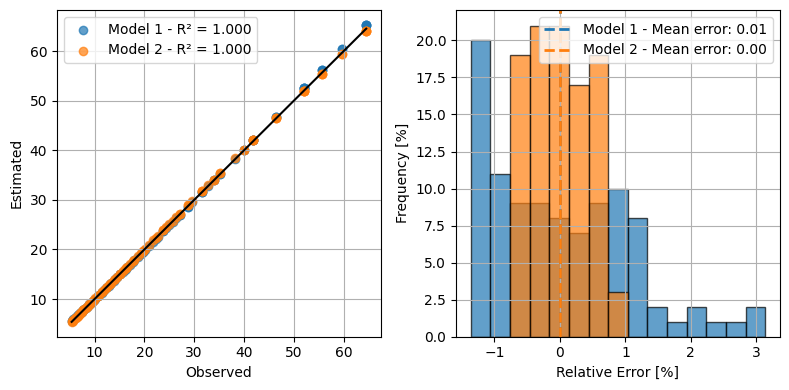

(<Figure size 800x400 with 2 Axes>,
 array([<Axes: xlabel='Observed', ylabel='Estimated'>,
        <Axes: xlabel='Relative Error [%]', ylabel='Frequency [%]'>],
       dtype=object))

In [8]:
# Set species and metric to estimate
species="Contrails"
metric="EGWP_ERF"

# Get results
results = fit_log_models(df, species=species, metric=metric)
print(results["eq1"])
print(results["eq2"])
print(f"Model 1 R²: {results['R2_1']:.4f}")
print(f"Model 2 R²: {results['R2_2']:.4f}")
plot_surrogate(results, bin_width=0.3)